# Predicting Bike Sharing Demand

In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import ylabel
from prompt_toolkit.shortcuts import set_title

# Data Exploration<br>

## Import Data

In [122]:
df_hour = pd.read_csv('bike+sharing+dataset/hour.csv')
# df_day = pd.read_csv('bike+sharing+dataset/day.csv')


## Overview of the Data

In [123]:
df_hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Look for missing Data / compare entries with Non-Null Count

In [124]:
df_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


## convert dteday to datetime

In [125]:
df_hour['dteday'] = pd.to_datetime(df_hour['dteday'])


## Statistics

In [126]:
df_hour.describe(include='number').style.background_gradient(cmap='Pastel1')

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.000000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.029500,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.500000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.000000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.500000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.000000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


## Time-based analysis

Text(0.5, 1.0, 'Registered vs Casual')

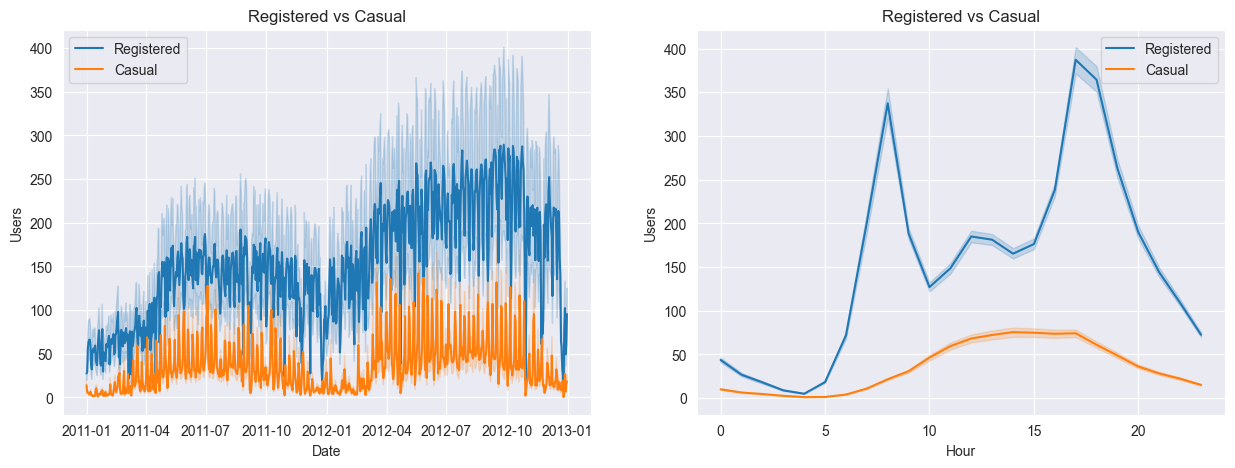

In [127]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))
# plt.figure(figsize=(8, 5))
sns.lineplot(data=df_hour, x='dteday', y='registered', label='Registered', ax=ax0)
sns.lineplot(data=df_hour, x='dteday', y='casual', label='Casual', ax=ax0)

ax0.set_xlabel('Date')
ax0.set_ylabel('Users')

ax0.set_title('Registered vs Casual')

sns.lineplot(data=df_hour, x='hr', y='registered', label='Registered', ax=ax1)
sns.lineplot(data=df_hour, x='hr', y='casual', label='Casual', ax=ax1)

ax1.set_xlabel('Hour')
ax1.set_ylabel('Users')
ax1.set_title('Registered vs Casual')


More registered users than casual users. The number of registered useres is raising more over 1 year than of the casual users

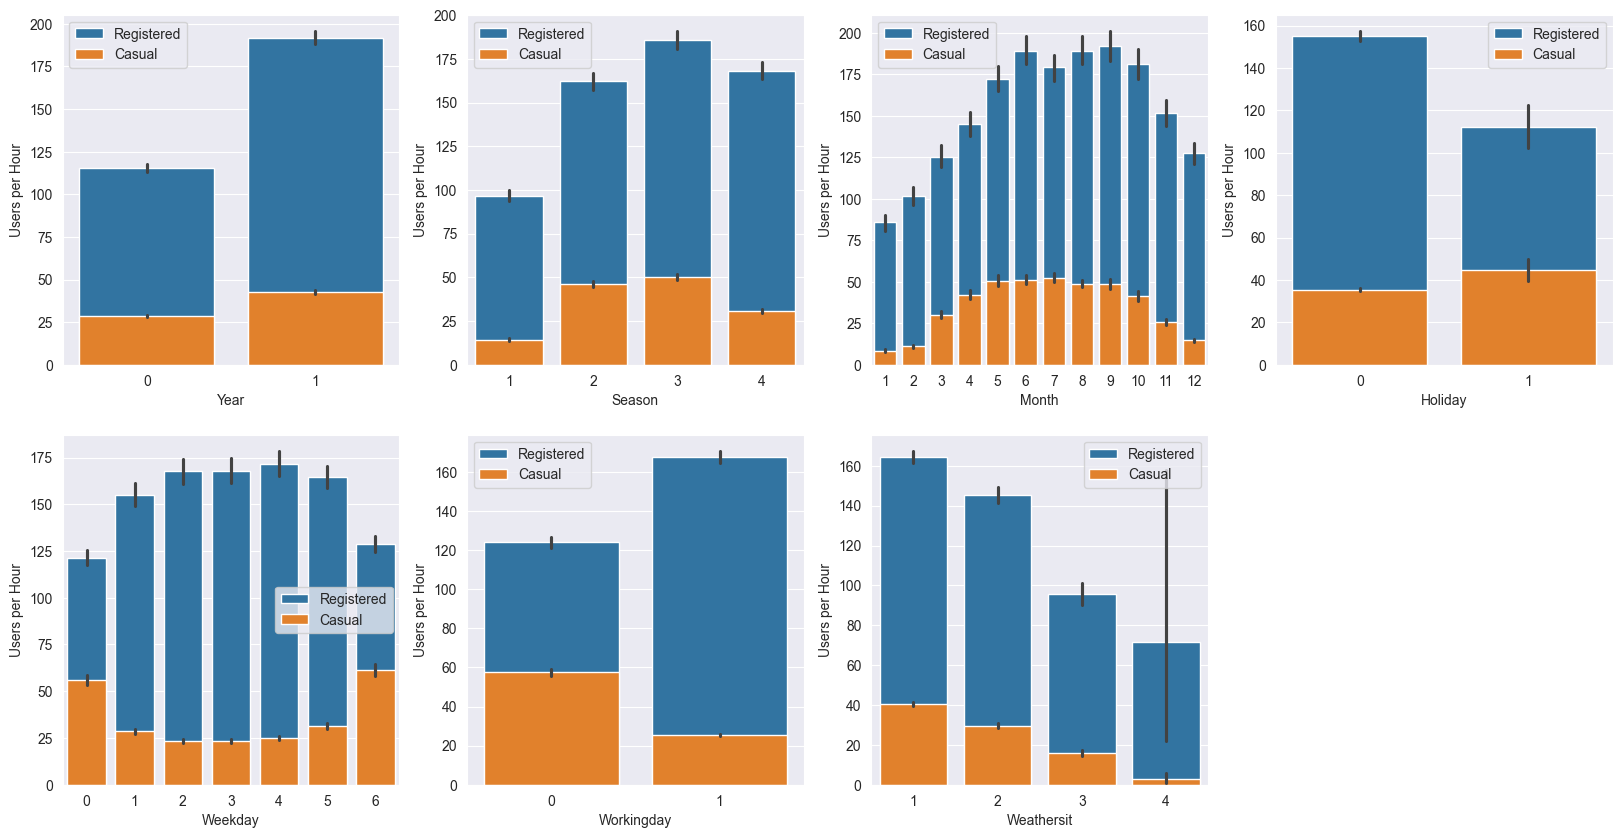

In [128]:
time_list = ['yr', 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

name_list = ['Year', 'Season', 'Month', 'Holiday', 'Weekday', 'Workingday', 'Weathersit']

fig, axes = plt.subplots(2, 4, figsize=(20,10))
axes = axes.flatten()
for i, col in enumerate(time_list):
    sns.barplot(data=df_hour, x=col, y='registered', ax=axes[i], label='Registered')
    sns.barplot(data=df_hour, x=col, y='casual', ax=axes[i], label='Casual')
    axes[i].set_xlabel(name_list[i])
    axes[i].set_ylabel('Users per Hour')

axes[7].set_visible(False)


Year: Bigger growth in registered users.<br>
Season: Season 3 is the strongest. Season 1 the weakest.<br>
Month: first month is the weakest. Ninth month the strongest.<br>
Holiday: fewer registered users on holidays but more casual users. Still less in general.<br>
Weekday: Day0 has the fewest users.<br>
Workingday: On working days the majority of users are registered. On non-working days its 50/50.<br>
Weathersit: most users Weathersit: 1.

## Distribution of Temperature / Correlation with users

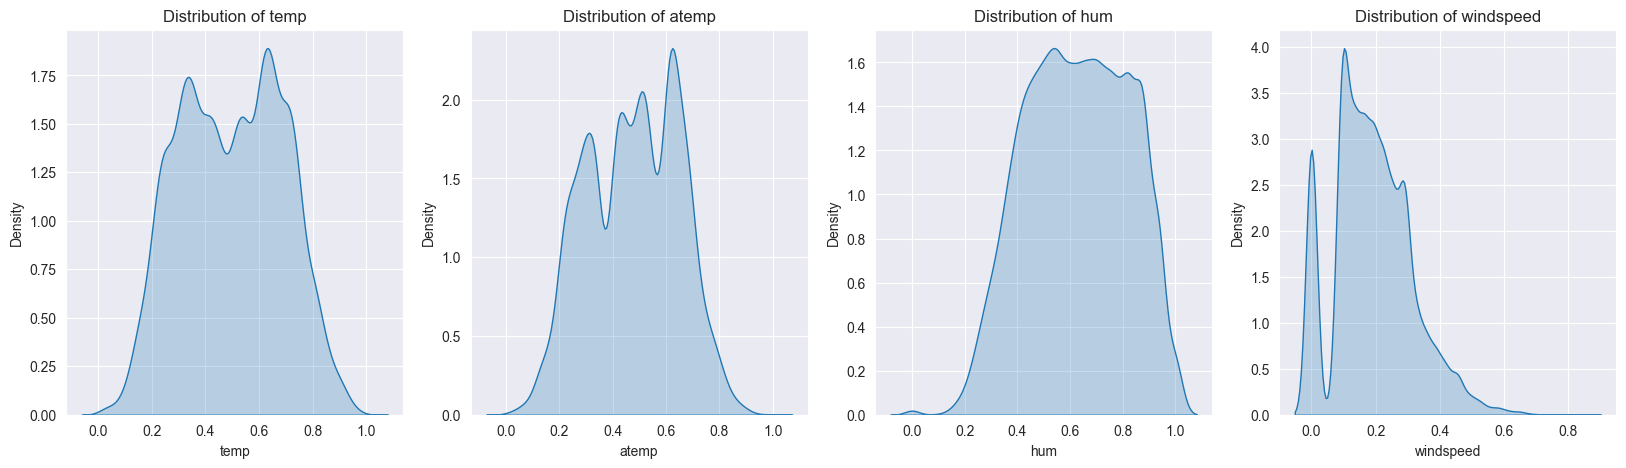

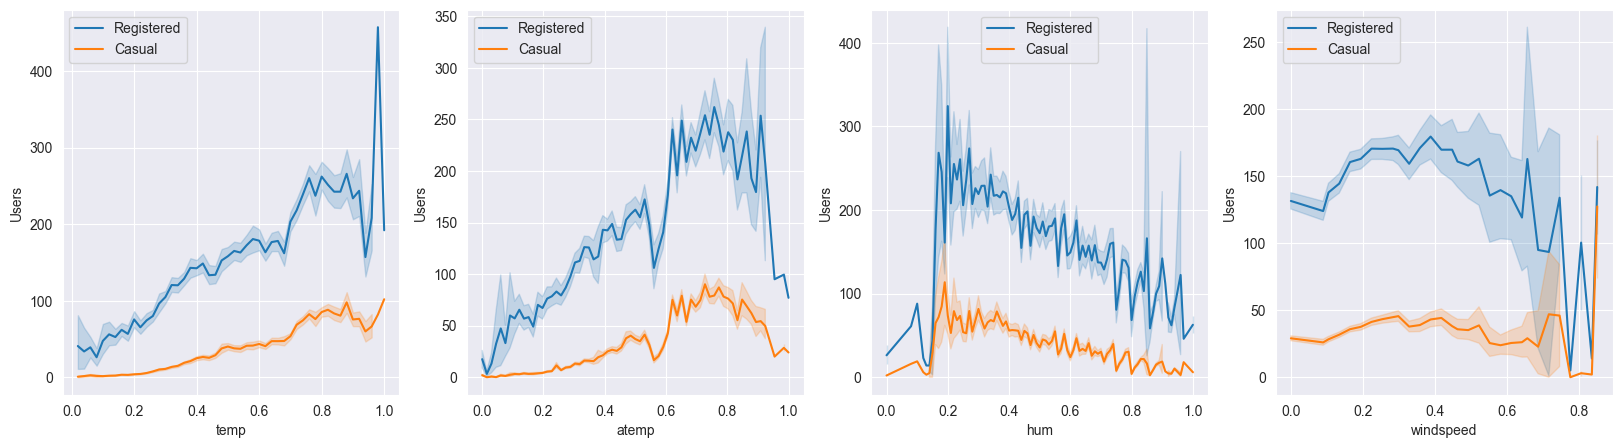

In [135]:
lst_values = ['temp', 'atemp', 'hum', 'windspeed']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

for i, col in enumerate(lst_values):
    sns.kdeplot(data=df_hour[col], fill=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
plt.show()
lst_values = ['temp', 'atemp', 'hum', 'windspeed']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

for i, value in enumerate(lst_values):
    sns.lineplot(data=df_hour, x=value, y='registered', ax=axes[i], label='Registered')
    sns.lineplot(data=df_hour, x=value, y='casual', ax=axes[i], label='Casual')
    axes[i].set_ylabel('Users')

There is no significant correlation

## Correlation

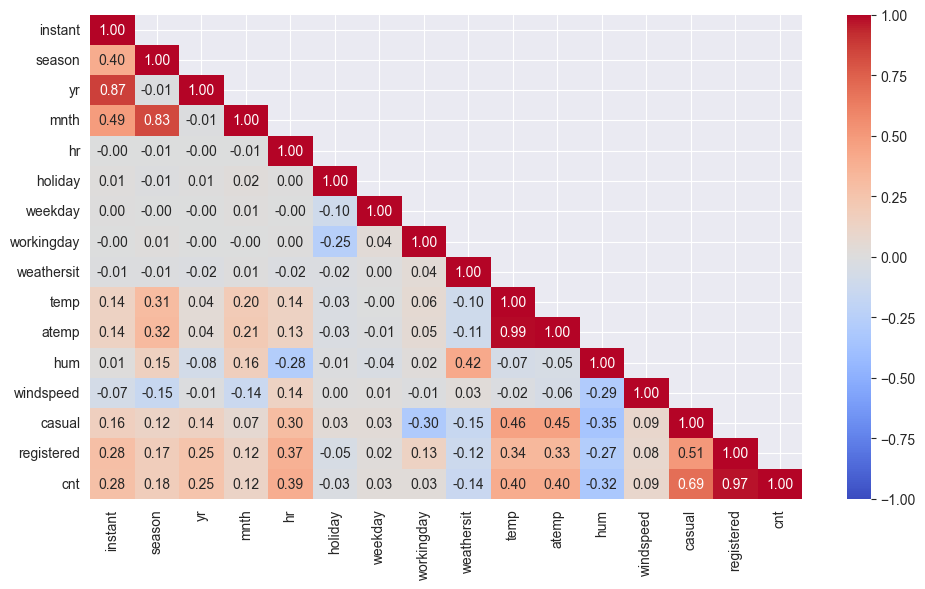

In [130]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
plt.figure(figsize=(10, 6))
sns.heatmap(corr, mask=mask, center=0, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='coolwarm')
plt.tight_layout()

## Clean Data

In [133]:
df_hour.drop(columns='instant')
df_hour.drop(columns='atemp')


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.56,0.1343,13,48,61
